In [1]:
# Package installation
# install.packages('dplyr')
# install.packages('jsonlite')
# install.packages('lubridate')
# install.packages('ggplot2')
# install.packages('quantmod')
# install.packages('lifecycle')
# install.packages('tidyselect')
# install.packages("tidyverse")
# install.packages("zoo")

# Install necessary packages for VAR model
# install.packages("tsibble")
# install.packages("feasts")
# install.packages("fabletools")


In [2]:
# Load necessary libraries
library(dplyr)
library(jsonlite)
library(lubridate)
library(ggplot2)
library(quantmod)
library(lifecycle)
library(tidyselect)
library(tidyverse)
library(zoo)
library(forecast)
library(tseries)

# Load necessary libraries for VAR model
library(tsibble)
library(feasts)
library(fabletools)




Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



Attaching package: 'lubridate'


The following objects are masked from 'package:base':

    date, intersect, setdiff, union


Loading required package: xts

Loading required package: zoo


Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric



######################### Warning from 'xts' package ##########################
#                                                                             #
# The dplyr lag() function breaks how base R's lag() function is supposed to  #
# work, which breaks lag(my_xts). Calls to lag(my_xts) that you type or       #
# source() into this session won't work correctly.                            #
#                                                                             #
# Use stats::la

In [3]:
# Read the CSV file into a dataframe
WIN_PRO_df <- read.csv("csv_files/win_data_pro.csv")
PLACE_PRO_df <- read.csv("csv_files/place_data_PRO.csv")

In [4]:
# Filter only on the rows where actual trades have been made
WIN_PRO_df <- WIN_PRO_df %>% filter(trades != "[]")
PLACE_PRO_df <- PLACE_PRO_df %>% filter(trades != "[]")

# Remove trades column
WIN_PRO_df <- WIN_PRO_df %>% select(-trades)
PLACE_PRO_df <- PLACE_PRO_df %>% select(-trades)

# Convert timestamp to POSIXct
WIN_PRO_df <- WIN_PRO_df %>%
  mutate(timestamp = as.POSIXct(timestamp_unix / 1000, origin = "1970-01-01", tz = "GMT"))

PLACE_PRO_df <- PLACE_PRO_df %>%
  mutate(timestamp = as.POSIXct(timestamp_unix / 1000, origin = "1970-01-01", tz = "GMT"))

# Create a equal frequency bin for time
WIN_PRO_df <- WIN_PRO_df %>%
  mutate(time_bucket = floor(as.numeric(timestamp) / 12))

PLACE_PRO_df <- PLACE_PRO_df %>%
  mutate(time_bucket = floor(as.numeric(timestamp) / 12))

# Create a size and price column. Price is set to last traded price, which is fine because we filtered out the rows with no trades.
#Hence price is now actual trades, and size will be worked out later for each horse.
WIN_PRO_df <- WIN_PRO_df %>%
  mutate(
    price = last_traded_price
  )

PLACE_PRO_df <- PLACE_PRO_df %>%
  mutate(
    price = last_traded_price
  )


In [5]:
###Check horse IDS
# Read the horse name data into a dataframe
horse_names_df <- data.frame(
  horse_id = c(8421889, 7560122, 5465145, 3415981, 5105924, 7401388),
  horse_name = c("Romsdal", "Brown Panther", "Havana Beat", "Times Up", "Snow Sky", "Island Remede")
)

In [6]:
# Join the horse name data with the main dataframe
WIN_PRO_df <- WIN_PRO_df %>%
  left_join(horse_names_df, by = c("horse_id" = "horse_id"))

PLACE_PRO_df <- PLACE_PRO_df %>%
  left_join(horse_names_df, by = c("horse_id" = "horse_id"))

In [7]:
# Important instances to split df
PP_t <- "2015-05-15 16:07:00"
IP_t <- "2015-05-15 16:16:00"

Bucket_size <- 12

# Split the data frame into three parts based on the given times
WIN_PRO_df_Morning <- WIN_PRO_df %>% filter(timestamp < PP_t)
WIN_PRO_df_PP <- WIN_PRO_df %>% filter(timestamp >= PP_t & timestamp < IP_t)
WIN_PRO_df_IP <- WIN_PRO_df %>% filter(timestamp >= IP_t)

PLACE_PRO_df_Morning <- PLACE_PRO_df %>% filter(timestamp < PP_t)
PLACE_PRO_df_PP <- PLACE_PRO_df %>% filter(timestamp >= PP_t & timestamp < IP_t)
PLACE_PRO_df_IP <- PLACE_PRO_df %>% filter(timestamp >= IP_t)

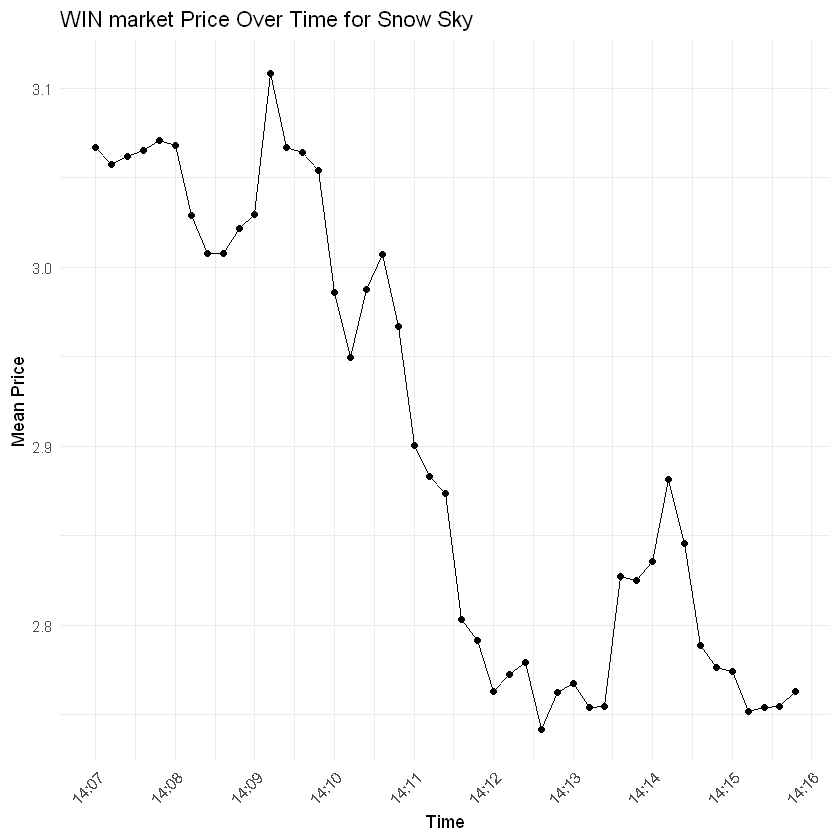

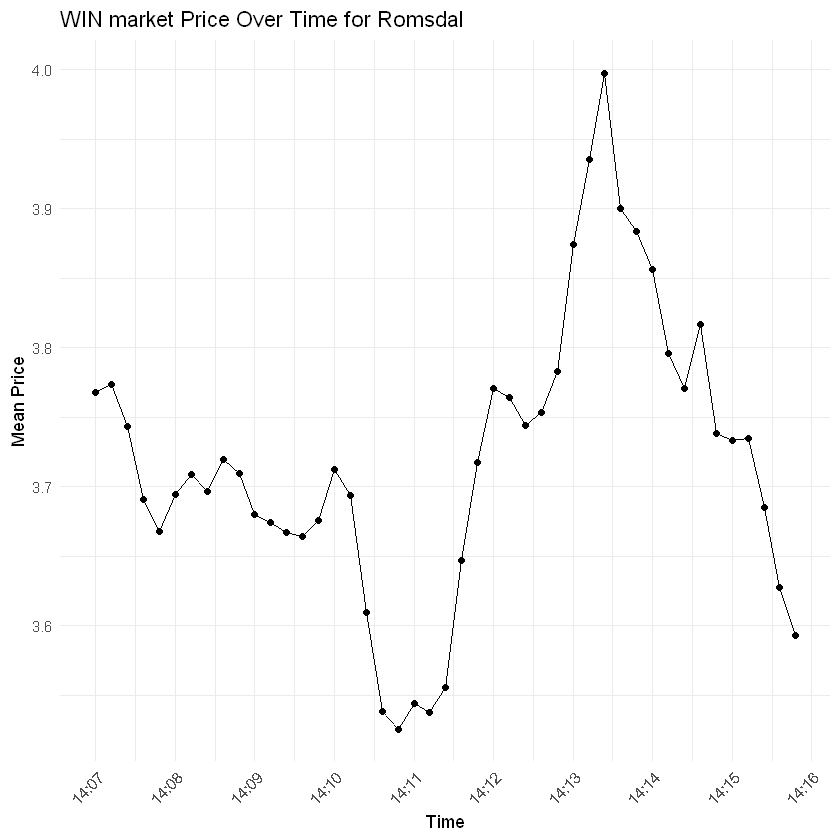

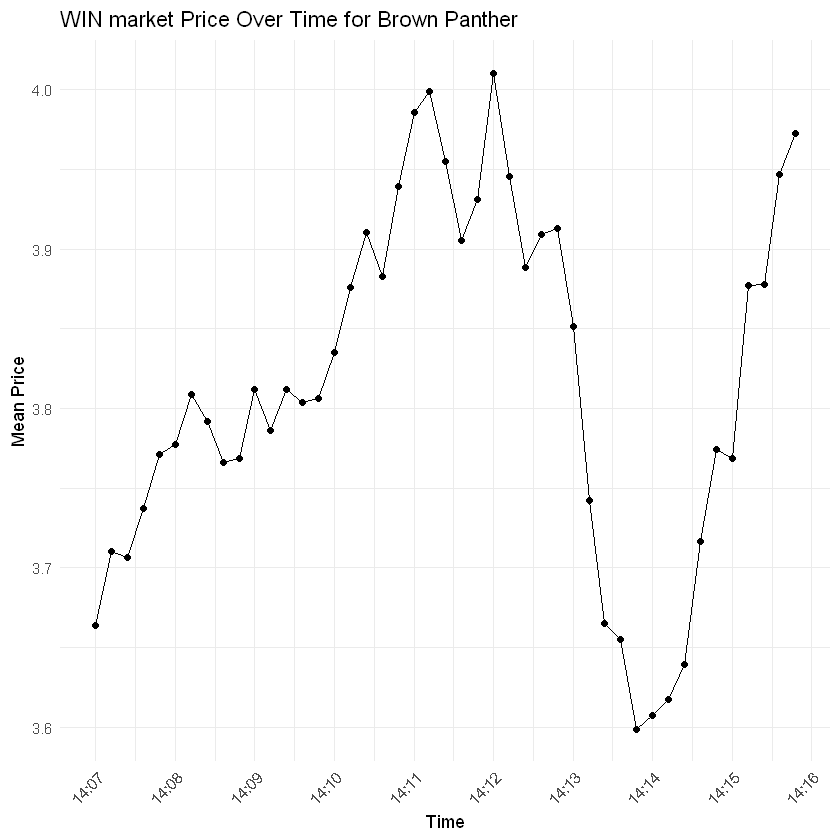

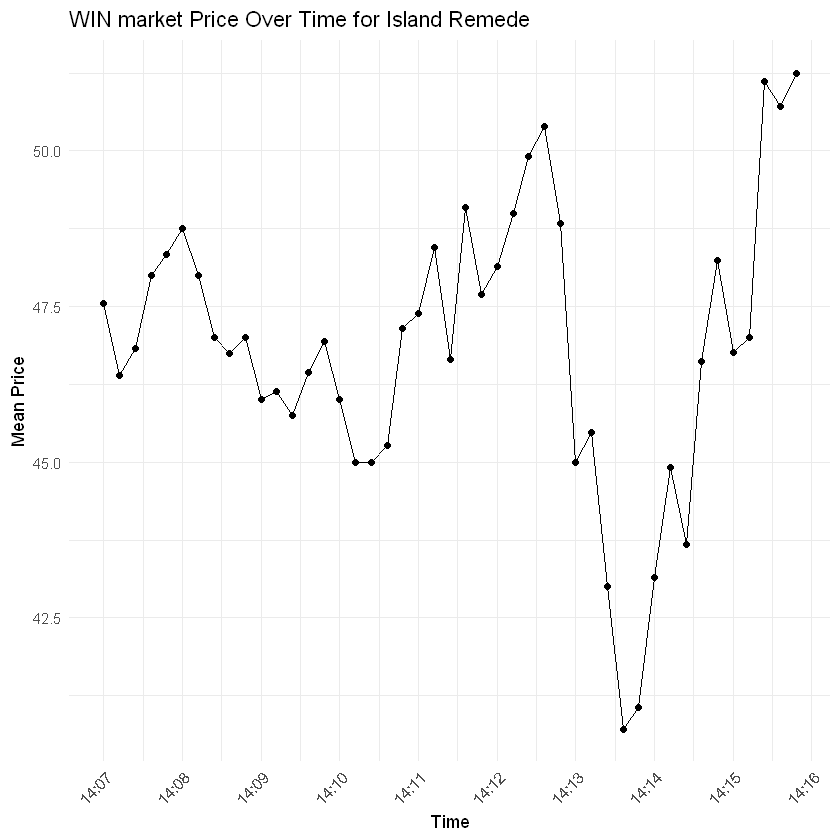

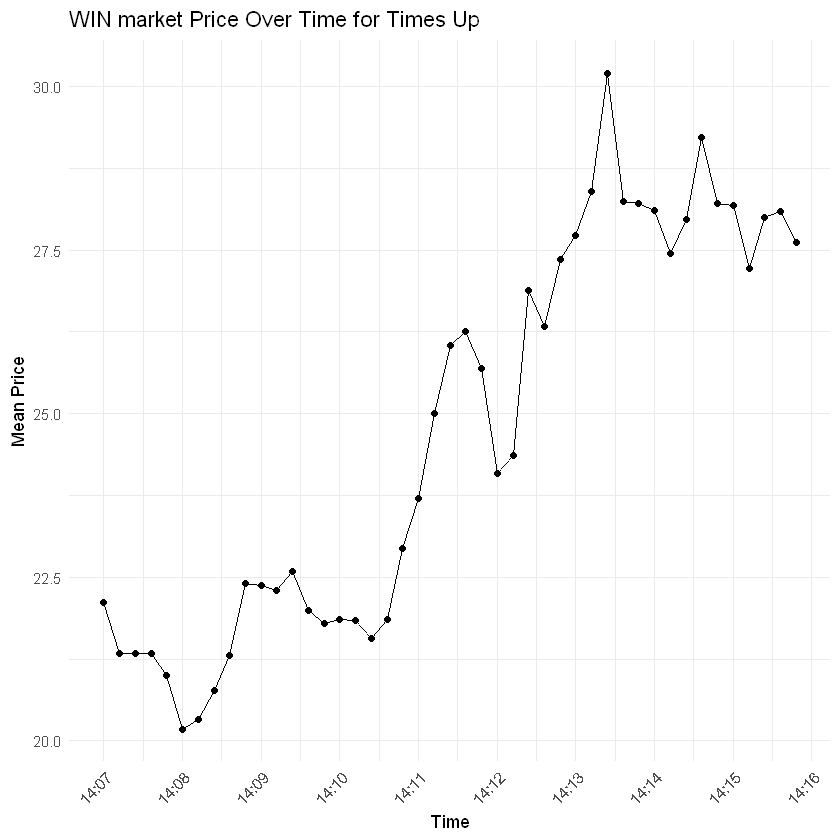

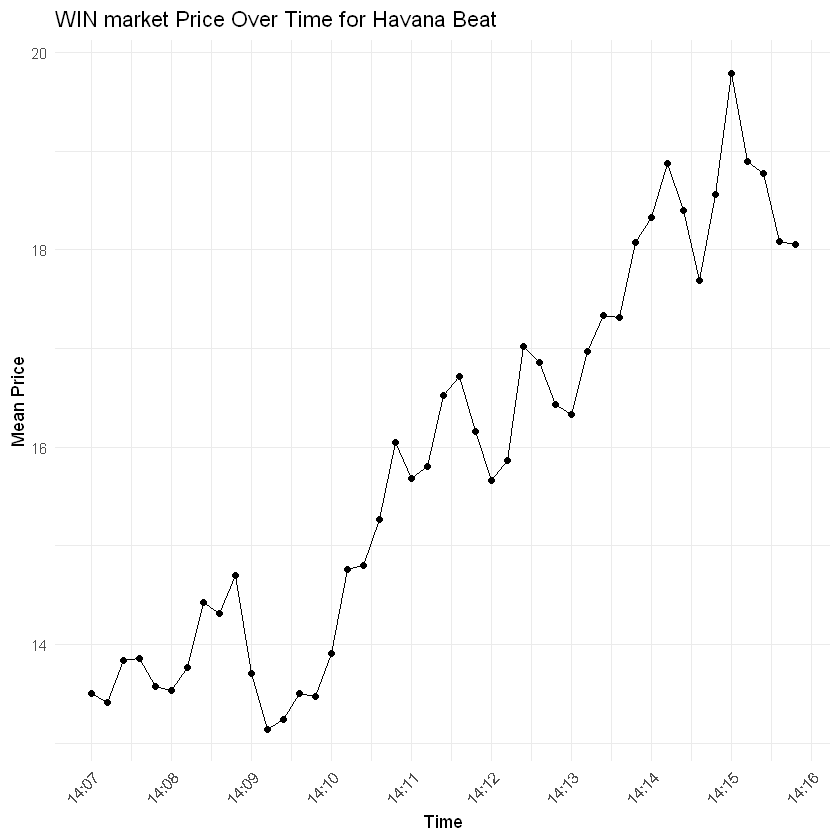

In [8]:


# Loop through each horse and create a plot and save dataframe for WIN_PRO_df
for (horse in unique(WIN_PRO_df$horse_name)) {
  horse_df <- WIN_PRO_df_PP %>% filter(horse_name == horse)
  
  # Group by time_bucket and calculate the size and Mean Price
  horse_df <- horse_df %>%
    group_by(time_bucket) %>%
    summarise(
      mean_price = mean(price, na.rm = TRUE)
    )
  
  # Save the horse-specific dataframe to a variable named after the horse
  assign(paste0(gsub(" ", "_", horse), "_WIN_df"), horse_df)



  
  # Create the plot with only price
  p <- ggplot(data = horse_df, aes(x = as.POSIXct(time_bucket * Bucket_size, origin = "1970-01-01", tz = "GMT"), y = mean_price)) +
    geom_line() +
    geom_point() +
    labs(
      title = paste("WIN market Price Over Time for", horse),
      x = "Time",
      y = "Mean Price"
    ) +
    theme_minimal() +
    theme(
      axis.text.x = element_text(angle = 45, hjust = 1),
      legend.position = "bottom"
    ) +
    scale_x_datetime(date_breaks = "1 min", date_labels = "%H:%M")
  
  # Print the plot
  print(p)
}
  

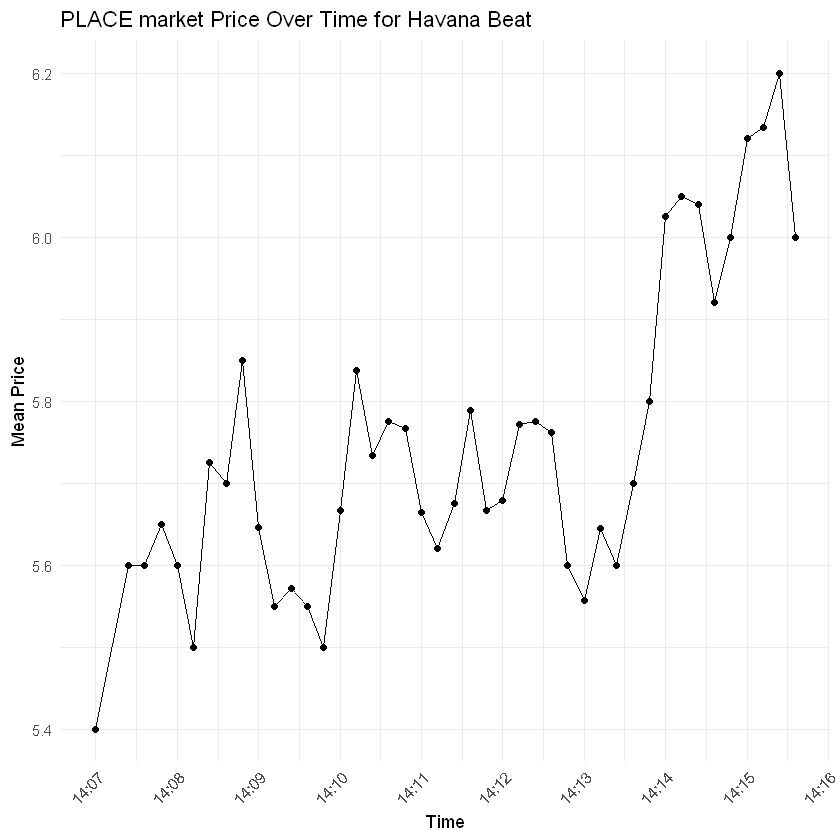

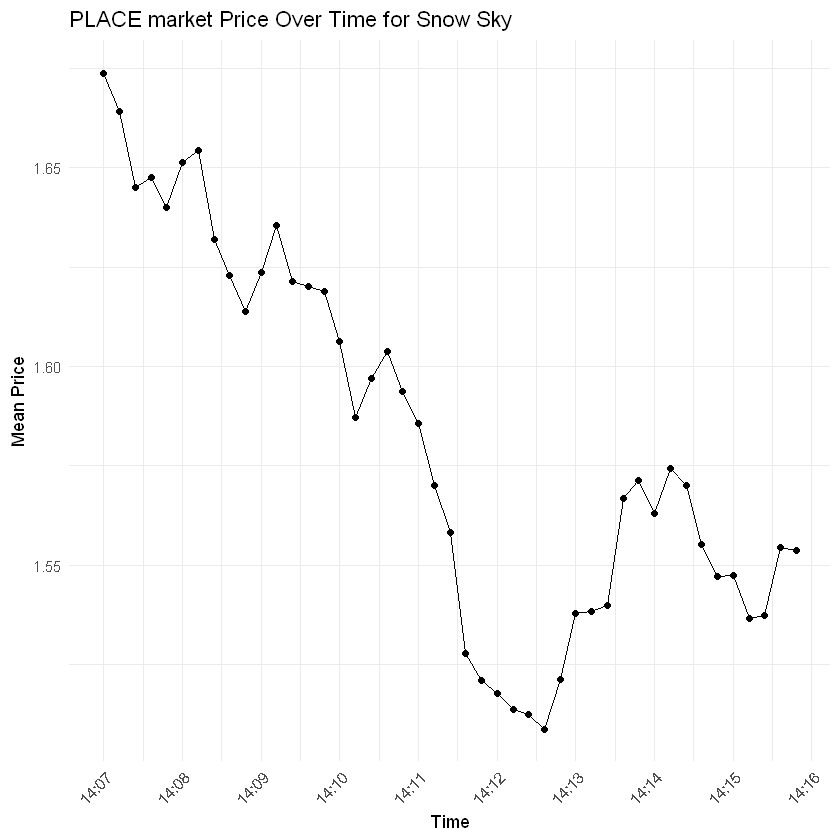

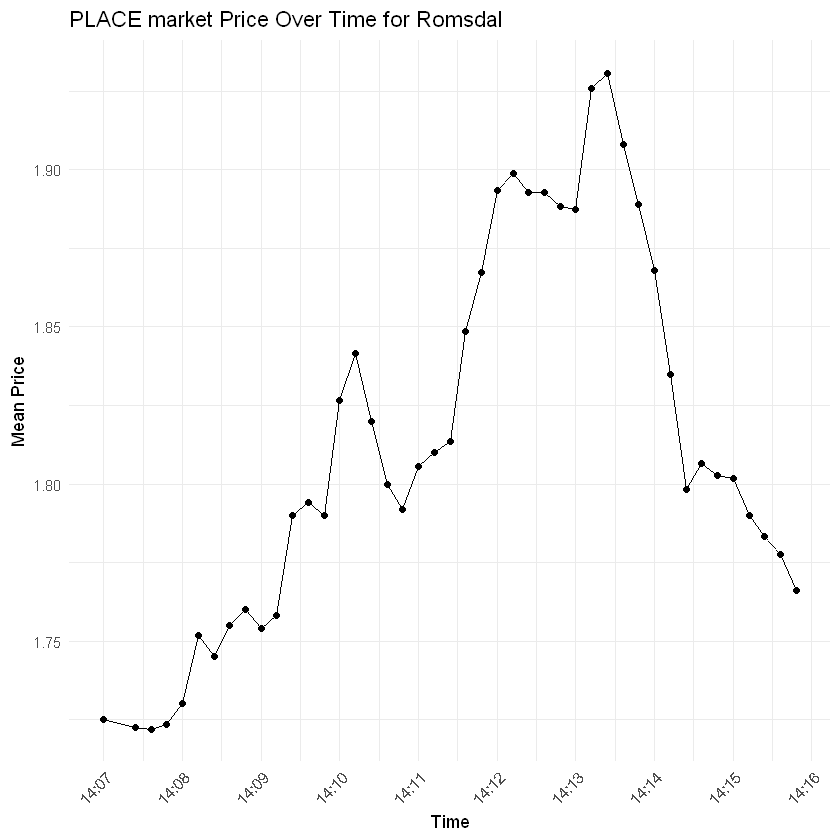

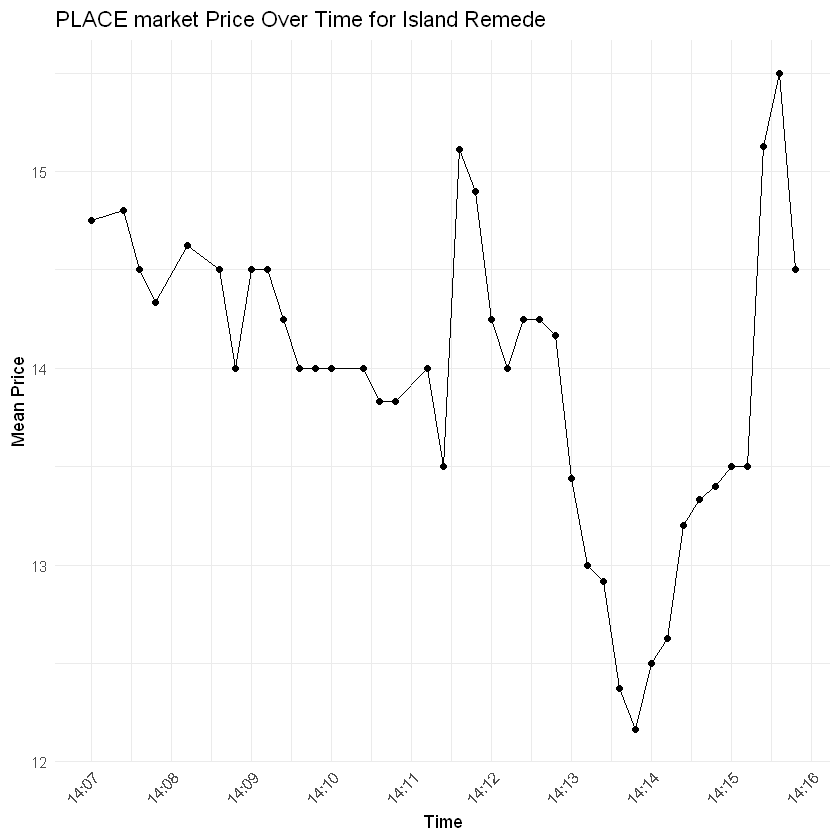

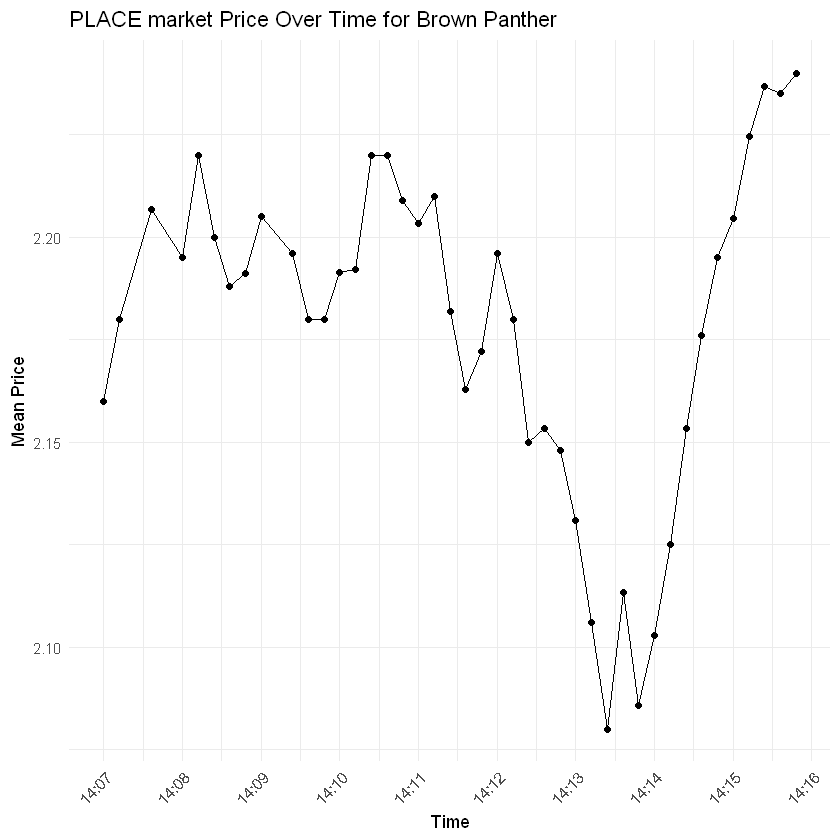

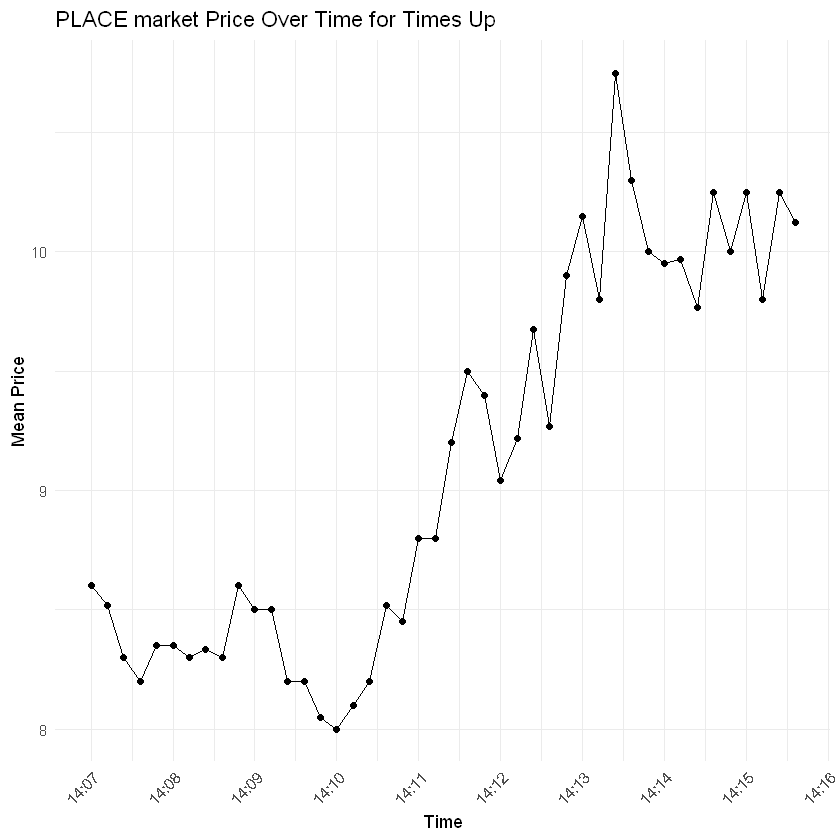

In [9]:
# Loop through each horse and create a plot and save dataframe for PLACE_PRO_df
for (horse in unique(PLACE_PRO_df$horse_name)) {
  horse_df <- PLACE_PRO_df_PP %>% filter(horse_name == horse)
  
  
  # Group by time_bucket and calculate the size and Mean Price
  horse_df <- horse_df %>%
    group_by(time_bucket) %>%
    summarise(
      #total_size = sum(size, na.rm = TRUE),
      #mean_price = sum(price * size, na.rm = TRUE) / sum(size, na.rm = TRUE)
      mean_price = mean(price, na.rm = TRUE)
    )
  
  # Save the horse-specific dataframe to a variable named after the horse
  assign(paste0(gsub(" ", "_", horse), "_PLACE_df"), horse_df)
  
  # Create the plot with only price
  p <- ggplot(data = horse_df, aes(x = as.POSIXct(time_bucket * Bucket_size, origin = "1970-01-01", tz = "GMT"), y = mean_price)) +
    geom_line() +
    geom_point() +
    labs(
      title = paste("PLACE market Price Over Time for", horse),
      x = "Time",
      y = "Mean Price"
    ) +
    theme_minimal() +
    theme(
      axis.text.x = element_text(angle = 45, hjust = 1),
      legend.position = "bottom"
    ) +
    scale_x_datetime(date_breaks = "1 min", date_labels = "%H:%M")
  
  # Print the plot
  print(p)
}

### EXPLORATORY DATA ANALYSIS WIN MARKET (SELECTING SNOW SKY)


In [10]:
head(Snow_Sky_WIN_df)
head(Snow_Sky_PLACE_df)

time_bucket,mean_price
<dbl>,<dbl>
119308235,3.067143
119308236,3.057292
119308237,3.062000
119308238,3.065385
119308239,3.070896
119308240,3.067778


time_bucket,mean_price
<dbl>,<dbl>
119308235,1.67375
119308236,1.66400
119308237,1.64500
119308238,1.64750
119308239,1.64000
119308240,1.65125


In [11]:
# Step 2: Data Exploration
# Summary statistics of key variables

print(summary(Snow_Sky_WIN_df$mean_price))
print(summary(Snow_Sky_PLACE_df$mean_price))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  2.742   2.774   2.881   2.902   3.029   3.109 
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.509   1.540   1.571   1.582   1.621   1.674 


In [12]:
# Check for missing and duplicates in the values
print(sum(is.na(Snow_Sky_WIN_df$mean_price)))
print(sum(is.na(Snow_Sky_PLACE_df$mean_price)))

# Check duplicate rows
print(sum(duplicated(Snow_Sky_WIN_df)))
print(sum(duplicated(Snow_Sky_PLACE_df)))

[1] 0
[1] 0
[1] 0
[1] 0


In [13]:
# Convert 'time_bucket' to POSIXct for proper time handling
Snow_Sky_WIN_df <- Snow_Sky_WIN_df %>%
  mutate(timestamp = as.POSIXct(time_bucket * Bucket_size, origin = "1970-01-01", tz = "GMT"))

# Check the range of the timestamp
start_time <- min(Snow_Sky_WIN_df$timestamp)
end_time <- max(Snow_Sky_WIN_df$timestamp)

# Create a sequence of time points from start to end with a step of 6 seconds
time_points <- seq(from = start_time, to = end_time, by = Bucket_size)

# Create a complete data frame with these time points
complete_data <- data.frame(timestamp = time_points)

# Merge with the original data to ensure alignment
complete_data <- complete_data %>%
  left_join(Snow_Sky_WIN_df, by = "timestamp")

# Fill missing prices with NA or any other method if necessary
complete_data <- complete_data %>%
  mutate(mean_price = ifelse(is.na(mean_price), NA, mean_price))

# Check the filled price data
summary(complete_data$mean_price)

# Extract the filled price data
filled_price_data <- complete_data$mean_price

# Create the time series object
# Use a lower frequency to match the length of the time series
# For example, assuming a reasonable periodicity within the data length
WIN_price_ts <- ts(filled_price_data, frequency = Bucket_size)

# Check the structure and length of the time series object
str(WIN_price_ts)
length(WIN_price_ts)

# Display the first few entries of the time series object
head(WIN_price_ts)



   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  2.742   2.774   2.881   2.902   3.029   3.109 

 Time-Series [1:45] from 1 to 4.67: 3.07 3.06 3.06 3.07 3.07 ...


[1] 45

,Jan,Feb,Mar,Apr,May,Jun
1,3.067143,3.057292,3.062000,3.065385,3.070896,3.067778


In [14]:
# Convert 'time_bucket' to POSIXct for proper time handling
Snow_Sky_PLACE_df <- Snow_Sky_PLACE_df %>%
  mutate(timestamp = as.POSIXct(time_bucket * Bucket_size, origin = "1970-01-01", tz = "GMT"))

# Check the range of the timestamp
start_time <- min(Snow_Sky_PLACE_df$timestamp)
end_time <- max(Snow_Sky_PLACE_df$timestamp)

# Create a sequence of time points from start to end with a step of 6 seconds
time_points <- seq(from = start_time, to = end_time, by = Bucket_size)

# Create a complete data frame with these time points
complete_data <- data.frame(timestamp = time_points)

# Merge with the original data to ensure alignment
complete_data <- complete_data %>%
  left_join(Snow_Sky_PLACE_df, by = "timestamp")

# Fill missing prices with NA or any other method if necessary
complete_data <- complete_data %>%
  mutate(mean_price = ifelse(is.na(mean_price), NA, mean_price))

# Check the filled price data
summary(complete_data$mean_price)

# Extract the filled price data
filled_price_data <- complete_data$mean_price

# Create the time series object
# Use a lower frequency to match the length of the time series
# For example, assuming a reasonable periodicity within the data length
PLACE_price_ts <- ts(filled_price_data, frequency = Bucket_size)

# Check the structure and length of the time series object
str(PLACE_price_ts)
length(PLACE_price_ts)

# Display the first few entries of the time series object
head(PLACE_price_ts)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.509   1.540   1.571   1.582   1.621   1.674 

 Time-Series [1:45] from 1 to 4.67: 1.67 1.66 1.64 1.65 1.64 ...


[1] 45

,Jan,Feb,Mar,Apr,May,Jun
1,1.67375,1.66400,1.64500,1.64750,1.64000,1.65125


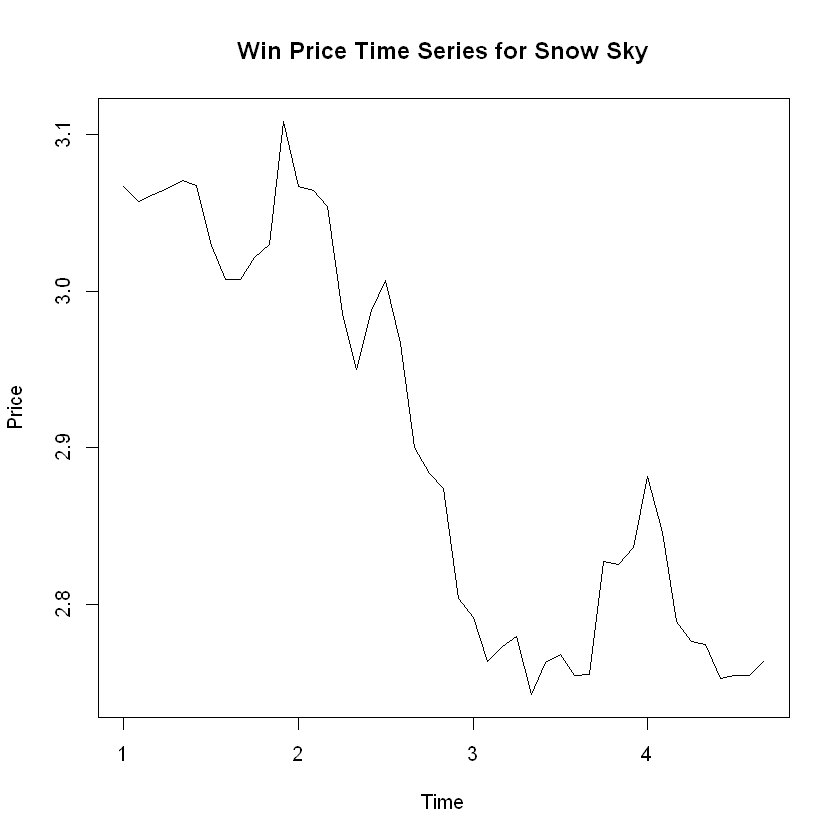

In [15]:
plot(WIN_price_ts, main="Win Price Time Series for Snow Sky", xlab="Time", ylab="Price", type="l")


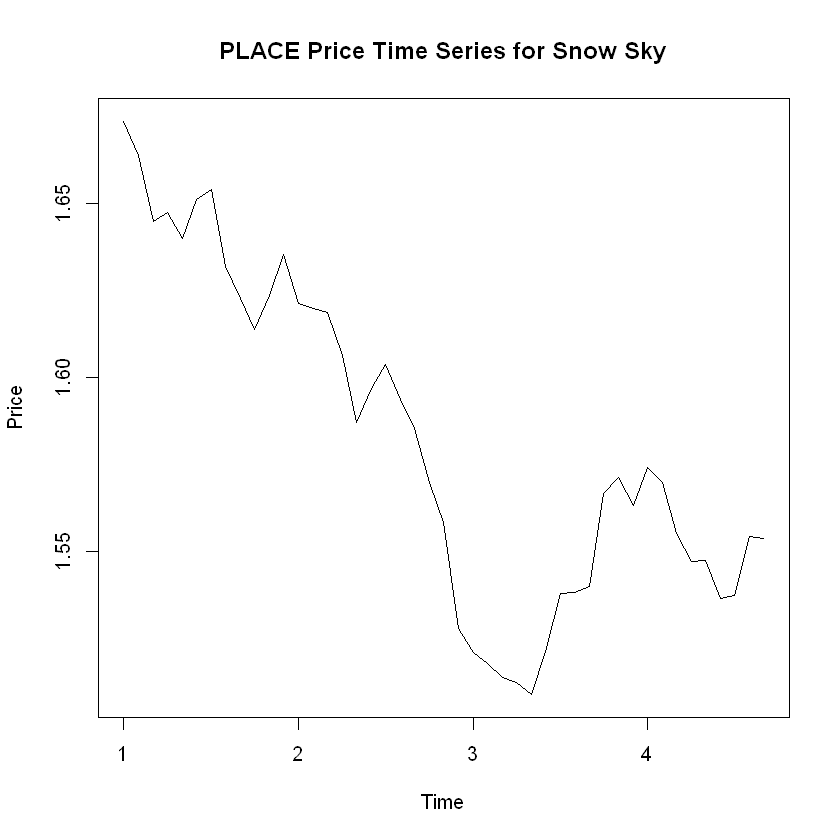

In [16]:
plot(PLACE_price_ts, main="PLACE Price Time Series for Snow Sky", xlab="Time", ylab="Price", type="l")

In [17]:
# Step 4: Statistical Tests
# Testing for stationarity
adf_test_result <- adf.test(WIN_price_ts, alternative = "stationary")
print(adf_test_result)

adf_test_result_2 <- adf.test(PLACE_price_ts, alternative = "stationary")
print(adf_test_result_2)




	Augmented Dickey-Fuller Test

data:  WIN_price_ts
Dickey-Fuller = -2.0381, Lag order = 3, p-value = 0.5587
alternative hypothesis: stationary


	Augmented Dickey-Fuller Test

data:  PLACE_price_ts
Dickey-Fuller = -1.7054, Lag order = 3, p-value = 0.6908
alternative hypothesis: stationary



Its not stationary. Therefore we need to break it down and to understand the underlying components.


In [18]:
#NOT SURE IF THIS IS REQUIRED?
# Enhanced boxplot visualization of monthly price distribution per year
# Snow_Sky_WIN_df %>%
#   mutate(year = year(timestamp), month = month(timestamp), month_name = month(timestamp, label = TRUE)) %>%
#   ggplot(aes(x = month_name, y = price, fill = month_name)) +  # Use month name and fill by month
#   geom_boxplot(outlier.shape = NA) +  # Remove default outlier points
#   geom_jitter(width = 0.1, alpha = 0.5, color = "darkgray") +  # Add jittered points for individual data observation
#   scale_fill_brewer(palette = "Paired") +  # Apply a color palette for aesthetics
#   labs(title = "Price Distribution ",
#        subtitle = "Snow Sky",) +
#   facet_wrap(~year) +  # Facet by year to see year-wise trends
#   theme_minimal() +  # Use a minimal theme
#   theme(
#     strip.background = element_rect(fill = "lightblue", color = "deepskyblue", size = 1),  # Customize facet headers
#     strip.text = element_text(face = "bold"),  # Bold facet header text
#     axis.text.x = element_text(angle = 45, hjust = 1),  # Improve x-axis label readability
#     legend.position = "none",  # Hide the legend as the color is self-explanatory
#     plot.title = element_text(hjust = 0.5),  # Center the title
#     plot.subtitle = element_text(hjust = 0.5)  # Center the subtitle
#   )


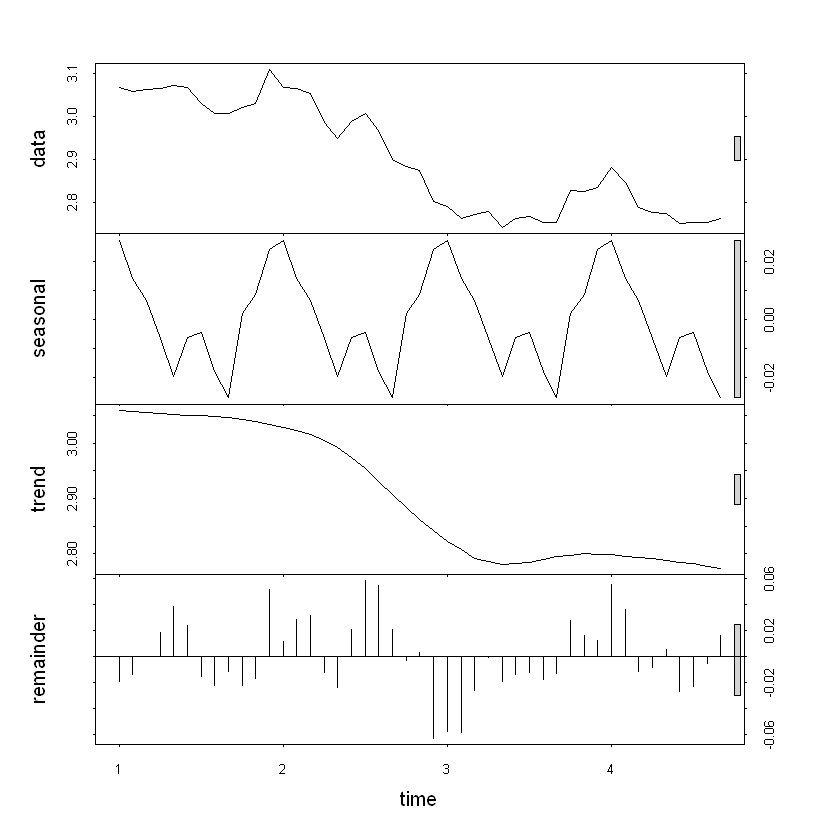

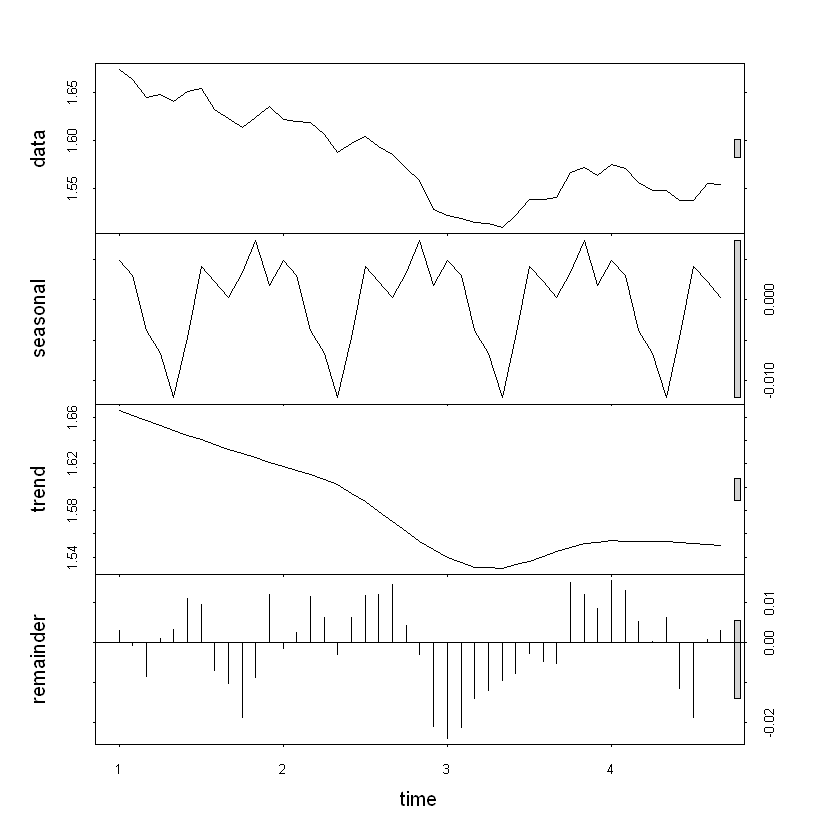

In [19]:
# Step 5: Decomposition of Time Series (if seasonal patterns expected)
decomposed <- stl(WIN_price_ts, s.window = "periodic")
plot(decomposed)

decomposed_2 <- stl(PLACE_price_ts, s.window = "periodic")
plot(decomposed_2)



In [20]:
snow_sky_W_diff1 <- diff(Snow_Sky_WIN_df$mean_price, lag = 1)

snow_sky_P_diff1 <- diff(Snow_Sky_PLACE_df$mean_price, lag = 1)


In [21]:
tail(Snow_Sky_WIN_df)
tail(Snow_Sky_PLACE_df)

head(Snow_Sky_WIN_df)
head(Snow_Sky_PLACE_df)
dim(Snow_Sky_WIN_df)
dim(Snow_Sky_PLACE_df)

# check duplicates in both dfs

sum(duplicated(Snow_Sky_WIN_df))

sum(duplicated(Snow_Sky_PLACE_df))

time_bucket,mean_price,timestamp
<dbl>,<dbl>,<dttm>
119308274,2.776316,2015-05-15 14:14:48
119308275,2.774062,2015-05-15 14:15:00
119308276,2.752083,2015-05-15 14:15:12
119308277,2.754286,2015-05-15 14:15:24
119308278,2.754634,2015-05-15 14:15:36
119308279,2.763273,2015-05-15 14:15:48


time_bucket,mean_price,timestamp
<dbl>,<dbl>,<dttm>
119308274,1.547273,2015-05-15 14:14:48
119308275,1.547500,2015-05-15 14:15:00
119308276,1.536667,2015-05-15 14:15:12
119308277,1.537500,2015-05-15 14:15:24
119308278,1.554444,2015-05-15 14:15:36
119308279,1.553750,2015-05-15 14:15:48


time_bucket,mean_price,timestamp
<dbl>,<dbl>,<dttm>
119308235,3.067143,2015-05-15 14:07:00
119308236,3.057292,2015-05-15 14:07:12
119308237,3.062000,2015-05-15 14:07:24
119308238,3.065385,2015-05-15 14:07:36
119308239,3.070896,2015-05-15 14:07:48
119308240,3.067778,2015-05-15 14:08:00


time_bucket,mean_price,timestamp
<dbl>,<dbl>,<dttm>
119308235,1.67375,2015-05-15 14:07:00
119308236,1.66400,2015-05-15 14:07:12
119308237,1.64500,2015-05-15 14:07:24
119308238,1.64750,2015-05-15 14:07:36
119308239,1.64000,2015-05-15 14:07:48
119308240,1.65125,2015-05-15 14:08:00


[1] 45  3

[1] 45  3

[1] 0

[1] 0

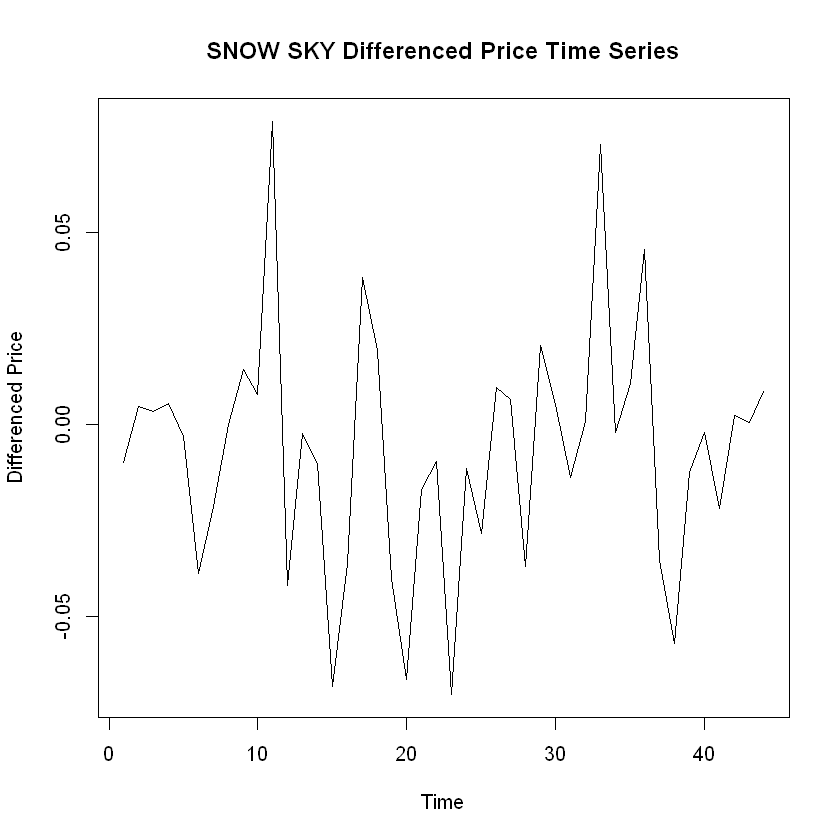

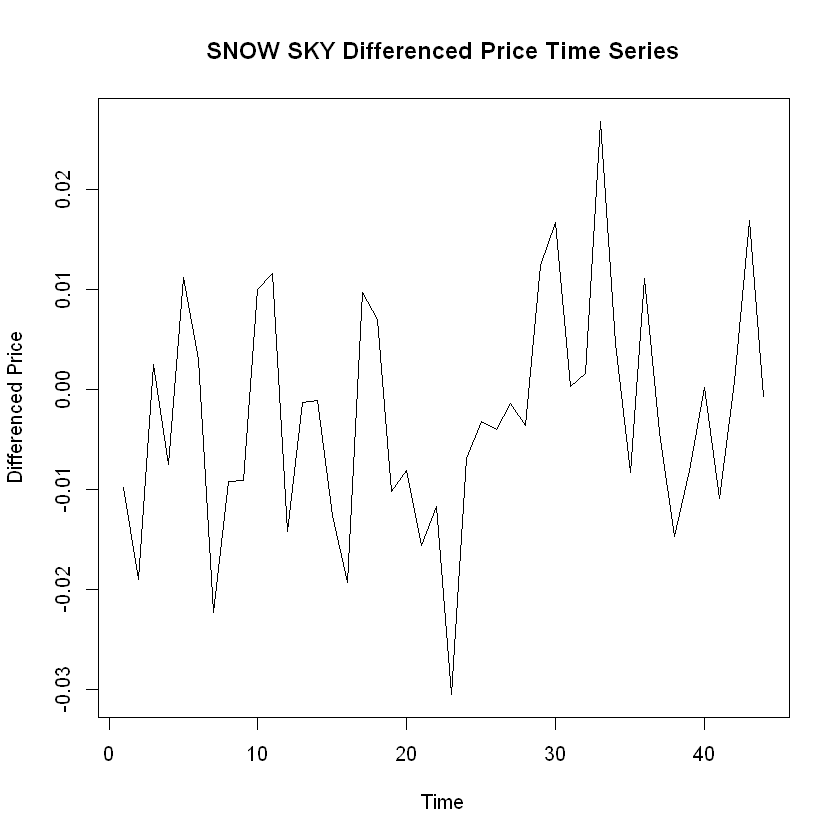

In [22]:
plot(snow_sky_W_diff1, main="SNOW SKY Differenced Price Time Series", xlab="Time", ylab="Differenced Price", type="l")

plot(snow_sky_P_diff1, main="SNOW SKY Differenced Price Time Series", xlab="Time", ylab="Differenced Price", type="l")

In [23]:
adf_result_diff <- adf.test(snow_sky_W_diff1, alternative = "stationary")
print(adf_result_diff)

adf_result_diff_P <- adf.test(snow_sky_P_diff1, alternative = "stationary")
print(adf_result_diff_P)


	Augmented Dickey-Fuller Test

data:  snow_sky_W_diff1
Dickey-Fuller = -3.045, Lag order = 3, p-value = 0.1601
alternative hypothesis: stationary


	Augmented Dickey-Fuller Test

data:  snow_sky_P_diff1
Dickey-Fuller = -2.8059, Lag order = 3, p-value = 0.2548
alternative hypothesis: stationary



#P-Value > 0.05, hence we take do another differential

In [24]:
snow_sky_W_diff2 <- diff(snow_sky_W_diff1, lag = 1)

snow_sky_P_diff2 <- diff(snow_sky_P_diff1, lag = 1)

In [25]:
adf.test(snow_sky_W_diff2, alternative = "stationary")

adf.test(snow_sky_P_diff2, alternative = "stationary")


	Augmented Dickey-Fuller Test

data:  snow_sky_W_diff2
Dickey-Fuller = -4.1923, Lag order = 3, p-value = 0.01125
alternative hypothesis: stationary


Warning message in adf.test(snow_sky_P_diff2, alternative = "stationary"):
"p-value smaller than printed p-value"



	Augmented Dickey-Fuller Test

data:  snow_sky_P_diff2
Dickey-Fuller = -4.5149, Lag order = 3, p-value = 0.01
alternative hypothesis: stationary


### VAR MODEL FOR WIN MARKET AND PLACE MARKET


In [26]:
# Check the size of both the time series

length(snow_sky_W_diff2)
length(snow_sky_P_diff2)

[1] 43

[1] 43

In [27]:
# Loading required package and importing data
# install.packages("vars")
# install.packages("tseries")
# install.packages("quantmod")
library(vars)
library(tseries)
library(quantmod)

Loading required package: MASS


Attaching package: 'MASS'


The following object is masked from 'package:dplyr':

    select


Loading required package: strucchange

Loading required package: sandwich


Attaching package: 'strucchange'


The following object is masked from 'package:stringr':

    boundary


Loading required package: urca

Loading required package: lmtest



In [58]:
# Estimating vector autoregression and testing for causality

VAR_est <- VAR(cbind(snow_sky_W_diff2,snow_sky_P_diff2), ic="AIC", lag.max = 6)
coeftest(VAR_est)
causality(VAR_est, cause="snow_sky_W_diff2")["Granger"]
causality(VAR_est, cause="snow_sky_P_diff2")["Granger"]

# Interpretation: The Granger-causality test states that at the 95% confidence interval, oil returns do significantly Granger-cause the inflation rate but not vice versa.




t test of coefficients:

                                        Estimate  Std. Error t value Pr(>|t|)  
snow_sky_W_diff2:(Intercept)          0.00033786  0.00681766  0.0496  0.96089  
snow_sky_W_diff2:snow_sky_W_diff2.l1 -0.84786183  0.31209175 -2.7167  0.01204 *
snow_sky_W_diff2:snow_sky_P_diff2.l1  0.66313491  1.07577551  0.6164  0.54342  
snow_sky_W_diff2:snow_sky_W_diff2.l2 -0.83422805  0.39995109 -2.0858  0.04780 *
snow_sky_W_diff2:snow_sky_P_diff2.l2  0.49834603  1.24610714  0.3999  0.69275  
snow_sky_W_diff2:snow_sky_W_diff2.l3 -0.62497149  0.40993808 -1.5246  0.14044  
snow_sky_W_diff2:snow_sky_P_diff2.l3  0.98987228  1.19660986  0.8272  0.41626  
snow_sky_W_diff2:snow_sky_W_diff2.l4 -0.60480323  0.42441665 -1.4250  0.16703  
snow_sky_W_diff2:snow_sky_P_diff2.l4  0.67474329  1.18830813  0.5678  0.57543  
snow_sky_W_diff2:snow_sky_W_diff2.l5 -0.64308894  0.39175679 -1.6416  0.11372  
snow_sky_W_diff2:snow_sky_P_diff2.l5  0.76586004  1.01782010  0.7525  0.45910  
snow_sky_W_dif

$Granger

	Granger causality H0: snow_sky_W_diff2 do not Granger-cause
	snow_sky_P_diff2

data:  VAR object VAR_est
F-Test = 2.1306, df1 = 6, df2 = 48, p-value = 0.06681



$Granger

	Granger causality H0: snow_sky_P_diff2 do not Granger-cause
	snow_sky_W_diff2

data:  VAR object VAR_est
F-Test = 0.18725, df1 = 6, df2 = 48, p-value = 0.979



In [59]:
summary(VAR_est)


VAR Estimation Results:
Endogenous variables: snow_sky_W_diff2, snow_sky_P_diff2 
Deterministic variables: const 
Sample size: 37 
Log Likelihood: 215.235 
Roots of the characteristic polynomial:
0.8851 0.8851 0.8503 0.8503 0.8311 0.8311 0.7776 0.7776 0.7108 0.7108 0.7092 0.7092
Call:
VAR(y = cbind(snow_sky_W_diff2, snow_sky_P_diff2), lag.max = 6, 
    ic = "AIC")


Estimation results for equation snow_sky_W_diff2: 
snow_sky_W_diff2 = snow_sky_W_diff2.l1 + snow_sky_P_diff2.l1 + snow_sky_W_diff2.l2 + snow_sky_P_diff2.l2 + snow_sky_W_diff2.l3 + snow_sky_P_diff2.l3 + snow_sky_W_diff2.l4 + snow_sky_P_diff2.l4 + snow_sky_W_diff2.l5 + snow_sky_P_diff2.l5 + snow_sky_W_diff2.l6 + snow_sky_P_diff2.l6 + const 

                      Estimate Std. Error t value Pr(>|t|)  
snow_sky_W_diff2.l1 -0.8478618  0.3120918  -2.717   0.0120 *
snow_sky_P_diff2.l1  0.6631349  1.0757755   0.616   0.5434  
snow_sky_W_diff2.l2 -0.8342280  0.3999511  -2.086   0.0478 *
snow_sky_P_diff2.l2  0.4983460  1.2461071   

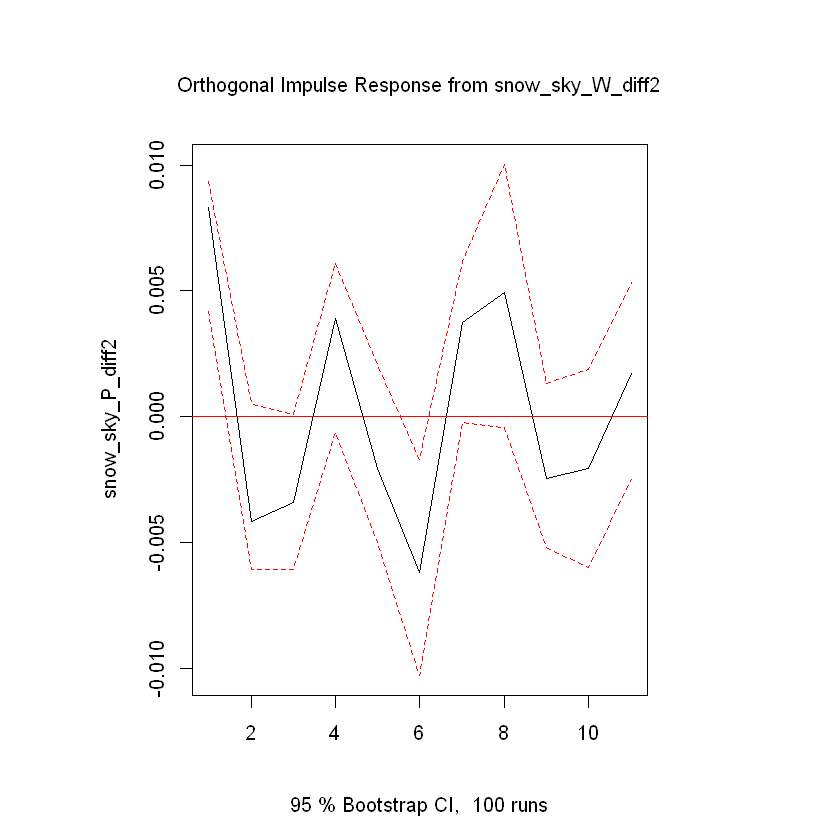

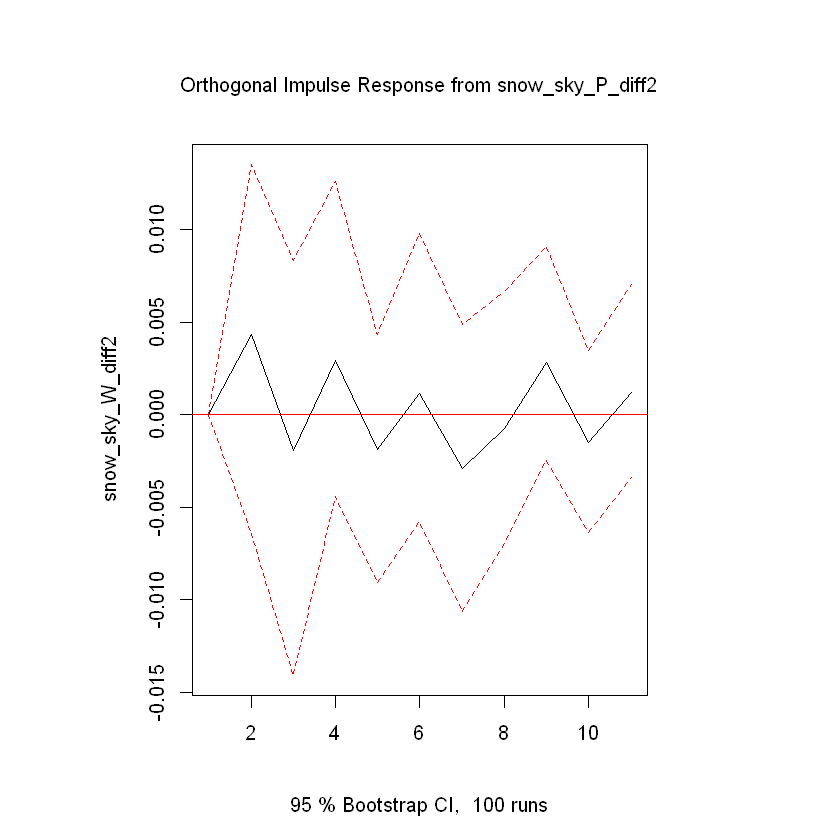

In [48]:
# Degression: Plotting impulse response functions
plot(irf(VAR_est, impulse="snow_sky_W_diff2", response="snow_sky_P_diff2"))
plot(irf(VAR_est, impulse="snow_sky_P_diff2", response="snow_sky_W_diff2"))

# Interpretation: A shock in the inflation rate does not have an effect on oil returns, whereas a shock in oil returns has a positive effect on the inflation rate in the first months after the shock.